In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.semi_random_player import SemiRandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
MODEL_VERSION = 'v10'
TRAIN_MODE = 'semi_random' # self_play / random / semi_random
INITIAL_BID_NORMALIZER = 100 # 100 if action is relative to current coins, 200 if relative to total coins

In [4]:
def run_validation(players, n_episodes_validation):
    game_controller = GameController()
    validation_players = [players[0], SemiRandomPlayer(1, game_controller.game)]
    game_controller.load_validation(validation_players)

    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [5]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/INITIAL_BID_NORMALIZER
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [6]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [7]:
def create_animation(critic_values_by_episode, drl_player, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_player, critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [8]:
def init_train(game_controller, players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):
        game_controller.load_train(players)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=10)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                game_controller.players[0].update_epsilon(eps)
                if TRAIN_MODE == 'self_play':
                    game_controller.players[1].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    players[0].agent.save_model(f'../checkpoints/{MODEL_VERSION}_checkpoint_episode_{i}.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, players[0], filename=f'../animations/{MODEL_VERSION}_critic_values_episode_{i}.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [9]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [10]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path=f'../checkpoints/{MODEL_VERSION}_checkpoint.pt'
)

Episode # 100  |  Val. Score: -0.40   |  Avg. Val. Score: -0.40  |  Epsilon: 0.993
                  Actor Loss: ------  |  Critic Loss: ------     |  Time Elapsed: 1.19s
Episode # 200  |  Val. Score: -0.70   |  Avg. Val. Score: -0.55  |  Epsilon: 0.985
                  Actor Loss: +0.059  |  Critic Loss: +0.071     |  Time Elapsed: 32.00s
Episode # 300  |  Val. Score: -0.40   |  Avg. Val. Score: -0.50  |  Epsilon: 0.978
                  Actor Loss: +0.069  |  Critic Loss: +0.066     |  Time Elapsed: 79.31s
Episode # 400  |  Val. Score: -0.40   |  Avg. Val. Score: -0.47  |  Epsilon: 0.970
                  Actor Loss: +0.060  |  Critic Loss: +0.071     |  Time Elapsed: 124.83s
Episode # 500  |  Val. Score: +0.30   |  Avg. Val. Score: -0.32  |  Epsilon: 0.963
                  Actor Loss: +0.072  |  Critic Loss: +0.072     |  Time Elapsed: 172.84s
Checkpoint saved!
Episode # 600  |  Val. Score: +0.10   |  Avg. Val. Score: -0.25  |  Epsilon: 0.956
                  Actor Loss: +0.113  

Episode #4800  |  Val. Score: +0.20   |  Avg. Val. Score: +0.50  |  Epsilon: 0.698
                  Actor Loss: -0.725  |  Critic Loss: +0.142     |  Time Elapsed: 2331.75s
Episode #4900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.44  |  Epsilon: 0.692
                  Actor Loss: -0.710  |  Critic Loss: +0.148     |  Time Elapsed: 2383.92s
Episode #5000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.45  |  Epsilon: 0.687
                  Actor Loss: -0.729  |  Critic Loss: +0.132     |  Time Elapsed: 2434.49s
Checkpoint saved!
Episode #5100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.54  |  Epsilon: 0.682
                  Actor Loss: -0.768  |  Critic Loss: +0.136     |  Time Elapsed: 2485.39s
Episode #5200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.53  |  Epsilon: 0.677
                  Actor Loss: -0.706  |  Critic Loss: +0.153     |  Time Elapsed: 2535.59s
Episode #5300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.52  |  Epsilon: 0.672
                  Actor Loss:

Episode #9500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.68  |  Epsilon: 0.490
                  Actor Loss: -0.687  |  Critic Loss: +0.156     |  Time Elapsed: 4713.40s
Checkpoint saved!
Episode #9600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.487
                  Actor Loss: -0.759  |  Critic Loss: +0.138     |  Time Elapsed: 4765.59s
Episode #9700  |  Val. Score: +0.00   |  Avg. Val. Score: +0.61  |  Epsilon: 0.483
                  Actor Loss: -0.714  |  Critic Loss: +0.143     |  Time Elapsed: 4814.34s
Episode #9800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.61  |  Epsilon: 0.479
                  Actor Loss: -0.780  |  Critic Loss: +0.122     |  Time Elapsed: 4865.29s
Episode #9900  |  Val. Score: +0.30   |  Avg. Val. Score: +0.56  |  Epsilon: 0.476
                  Actor Loss: -0.738  |  Critic Loss: +0.127     |  Time Elapsed: 4915.25s
Episode #10000  |  Val. Score: +0.40   |  Avg. Val. Score: +0.54  |  Epsilon: 0.472
                  Actor Loss

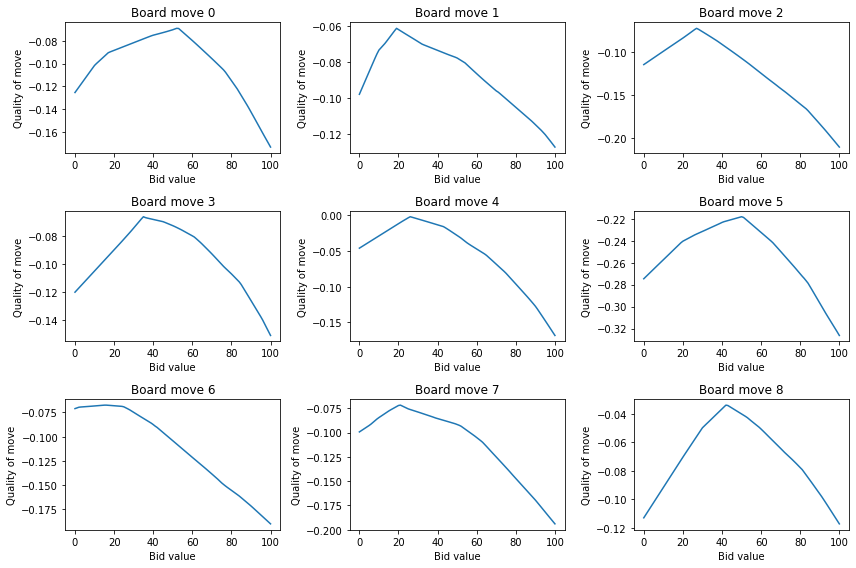

Animation of critic values saved!
Episode #10100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.56  |  Epsilon: 0.469
                  Actor Loss: -0.716  |  Critic Loss: +0.143     |  Time Elapsed: 5023.34s
Episode #10200  |  Val. Score: +0.30   |  Avg. Val. Score: +0.57  |  Epsilon: 0.465
                  Actor Loss: -0.754  |  Critic Loss: +0.133     |  Time Elapsed: 5074.26s
Episode #10300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.57  |  Epsilon: 0.462
                  Actor Loss: -0.699  |  Critic Loss: +0.151     |  Time Elapsed: 5124.39s
Episode #10400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.53  |  Epsilon: 0.458
                  Actor Loss: -0.703  |  Critic Loss: +0.157     |  Time Elapsed: 5175.79s
Episode #10500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.52  |  Epsilon: 0.455
                  Actor Loss: -0.741  |  Critic Loss: +0.135     |  Time Elapsed: 5226.74s
Checkpoint saved!
Episode #10600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.50  |  Epsi

Episode #14700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.332
                  Actor Loss: -0.759  |  Critic Loss: +0.121     |  Time Elapsed: 7413.59s
Episode #14800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.330
                  Actor Loss: -0.737  |  Critic Loss: +0.136     |  Time Elapsed: 7466.42s
Episode #14900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.66  |  Epsilon: 0.327
                  Actor Loss: -0.756  |  Critic Loss: +0.115     |  Time Elapsed: 7518.83s
Episode #15000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.70  |  Epsilon: 0.325
                  Actor Loss: -0.717  |  Critic Loss: +0.129     |  Time Elapsed: 7569.20s
Checkpoint saved!
Episode #15100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.66  |  Epsilon: 0.322
                  Actor Loss: -0.709  |  Critic Loss: +0.126     |  Time Elapsed: 7624.11s
Episode #15200  |  Val. Score: +0.50   |  Avg. Val. Score: +0.65  |  Epsilon: 0.320
                  Actor

Episode #19300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.235
                  Actor Loss: -0.744  |  Critic Loss: +0.148     |  Time Elapsed: 9863.24s
Episode #19400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.86  |  Epsilon: 0.233
                  Actor Loss: -0.765  |  Critic Loss: +0.129     |  Time Elapsed: 9917.08s
Episode #19500  |  Val. Score: +0.20   |  Avg. Val. Score: +0.78  |  Epsilon: 0.232
                  Actor Loss: -0.749  |  Critic Loss: +0.136     |  Time Elapsed: 9970.98s
Checkpoint saved!
Episode #19600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.78  |  Epsilon: 0.230
                  Actor Loss: -0.769  |  Critic Loss: +0.131     |  Time Elapsed: 10026.18s
Episode #19700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.76  |  Epsilon: 0.228
                  Actor Loss: -0.790  |  Critic Loss: +0.132     |  Time Elapsed: 10079.23s
Episode #19800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.73  |  Epsilon: 0.226
                  Act

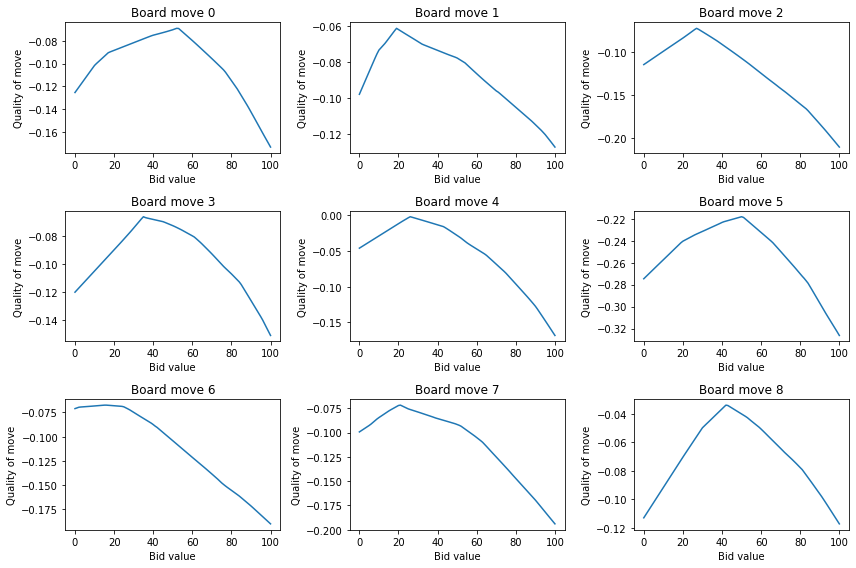

Animation of critic values saved!
Episode #20100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.69  |  Epsilon: 0.221
                  Actor Loss: -0.765  |  Critic Loss: +0.147     |  Time Elapsed: 10303.07s
Episode #20200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.220
                  Actor Loss: -0.779  |  Critic Loss: +0.131     |  Time Elapsed: 10357.66s
Episode #20300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.218
                  Actor Loss: -0.771  |  Critic Loss: +0.140     |  Time Elapsed: 10412.40s
Episode #20400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.68  |  Epsilon: 0.217
                  Actor Loss: -0.799  |  Critic Loss: +0.117     |  Time Elapsed: 10465.88s
Episode #20500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.72  |  Epsilon: 0.215
                  Actor Loss: -0.790  |  Critic Loss: +0.139     |  Time Elapsed: 10518.89s
Checkpoint saved!
Episode #20600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.68  | 

Episode #24700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.67  |  Epsilon: 0.157
                  Actor Loss: -0.820  |  Critic Loss: +0.138     |  Time Elapsed: 12796.77s
Episode #24800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.64  |  Epsilon: 0.156
                  Actor Loss: -0.799  |  Critic Loss: +0.143     |  Time Elapsed: 12850.27s
Episode #24900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.67  |  Epsilon: 0.154
                  Actor Loss: -0.807  |  Critic Loss: +0.135     |  Time Elapsed: 12902.06s
Episode #25000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.153
                  Actor Loss: -0.802  |  Critic Loss: +0.132     |  Time Elapsed: 12953.75s
Checkpoint saved!
Episode #25100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  |  Epsilon: 0.152
                  Actor Loss: -0.821  |  Critic Loss: +0.128     |  Time Elapsed: 13008.57s
Episode #25200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.151
                  

Episode #29300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.64  |  Epsilon: 0.111
                  Actor Loss: -0.810  |  Critic Loss: +0.127     |  Time Elapsed: 15315.24s
Episode #29400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.62  |  Epsilon: 0.110
                  Actor Loss: -0.809  |  Critic Loss: +0.141     |  Time Elapsed: 15370.51s
Episode #29500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.68  |  Epsilon: 0.109
                  Actor Loss: -0.812  |  Critic Loss: +0.136     |  Time Elapsed: 15422.23s
Checkpoint saved!
Episode #29600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.109
                  Actor Loss: -0.861  |  Critic Loss: +0.113     |  Time Elapsed: 15477.89s
Episode #29700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.71  |  Epsilon: 0.108
                  Actor Loss: -0.805  |  Critic Loss: +0.146     |  Time Elapsed: 15533.55s
Episode #29800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.78  |  Epsilon: 0.107
                  

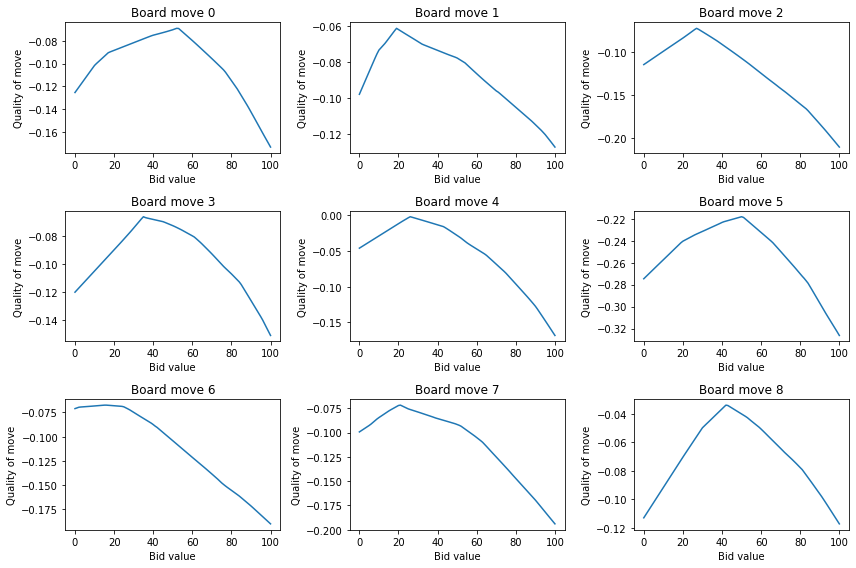

Animation of critic values saved!
Episode #30100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.105
                  Actor Loss: -0.828  |  Critic Loss: +0.121     |  Time Elapsed: 15769.73s
Episode #30200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.104
                  Actor Loss: -0.845  |  Critic Loss: +0.126     |  Time Elapsed: 15824.79s
Episode #30300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.103
                  Actor Loss: -0.824  |  Critic Loss: +0.138     |  Time Elapsed: 15880.61s
Episode #30400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.102
                  Actor Loss: -0.821  |  Critic Loss: +0.154     |  Time Elapsed: 15933.66s
Episode #30500  |  Val. Score: +0.50   |  Avg. Val. Score: +0.76  |  Epsilon: 0.102
                  Actor Loss: -0.815  |  Critic Loss: +0.139     |  Time Elapsed: 15988.91s
Checkpoint saved!
Episode #30600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.72  | 

Episode #34700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.75  |  Epsilon: 0.074
                  Actor Loss: -0.817  |  Critic Loss: +0.147     |  Time Elapsed: 18321.26s
Episode #34800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.074
                  Actor Loss: -0.851  |  Critic Loss: +0.136     |  Time Elapsed: 18376.37s
Episode #34900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.78  |  Epsilon: 0.073
                  Actor Loss: -0.834  |  Critic Loss: +0.121     |  Time Elapsed: 18431.48s
Episode #35000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.072
                  Actor Loss: -0.821  |  Critic Loss: +0.150     |  Time Elapsed: 18486.70s
Checkpoint saved!
Episode #35100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.78  |  Epsilon: 0.072
                  Actor Loss: -0.832  |  Critic Loss: +0.129     |  Time Elapsed: 18541.09s
Episode #35200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.76  |  Epsilon: 0.071
                  

Episode #39300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.78  |  Epsilon: 0.052
                  Actor Loss: -0.838  |  Critic Loss: +0.128     |  Time Elapsed: 20889.97s
Episode #39400  |  Val. Score: +0.30   |  Avg. Val. Score: +0.72  |  Epsilon: 0.052
                  Actor Loss: -0.858  |  Critic Loss: +0.122     |  Time Elapsed: 20944.93s
Episode #39500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.052
                  Actor Loss: -0.864  |  Critic Loss: +0.136     |  Time Elapsed: 20998.88s
Checkpoint saved!
Episode #39600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.72  |  Epsilon: 0.051
                  Actor Loss: -0.840  |  Critic Loss: +0.127     |  Time Elapsed: 21057.17s
Episode #39700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.051
                  Actor Loss: -0.836  |  Critic Loss: +0.137     |  Time Elapsed: 21113.52s
Episode #39800  |  Val. Score: +0.40   |  Avg. Val. Score: +0.68  |  Epsilon: 0.051
                  

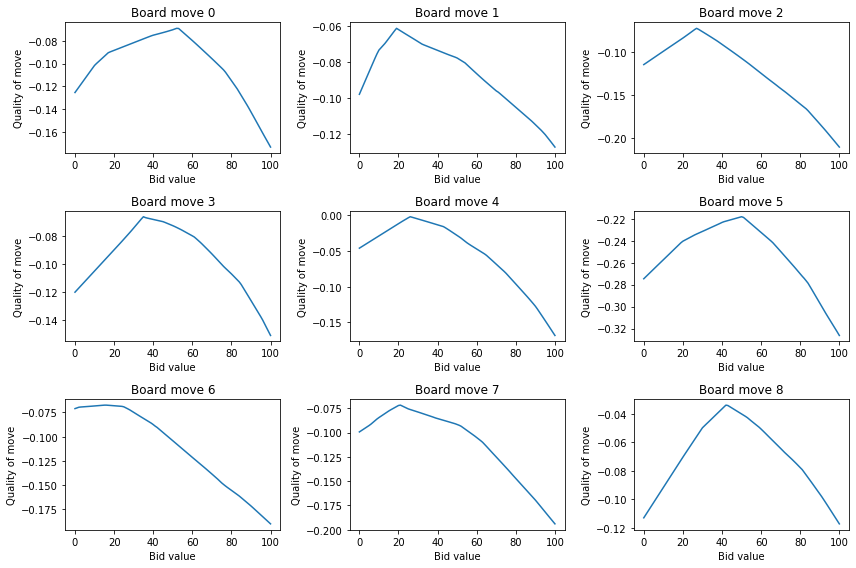

Animation of critic values saved!
Episode #40100  |  Val. Score: +0.50   |  Avg. Val. Score: +0.65  |  Epsilon: 0.049
                  Actor Loss: -0.824  |  Critic Loss: +0.128     |  Time Elapsed: 21353.60s
Episode #40200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.66  |  Epsilon: 0.049
                  Actor Loss: -0.840  |  Critic Loss: +0.133     |  Time Elapsed: 21409.52s
Episode #40300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.63  |  Epsilon: 0.049
                  Actor Loss: -0.834  |  Critic Loss: +0.125     |  Time Elapsed: 21464.39s
Episode #40400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.67  |  Epsilon: 0.048
                  Actor Loss: -0.826  |  Critic Loss: +0.152     |  Time Elapsed: 21520.73s
Episode #40500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.64  |  Epsilon: 0.048
                  Actor Loss: -0.837  |  Critic Loss: +0.125     |  Time Elapsed: 21576.10s
Checkpoint saved!
Episode #40600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.62  | 

Episode #44700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.035
                  Actor Loss: -0.879  |  Critic Loss: +0.129     |  Time Elapsed: 24004.21s
Episode #44800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.78  |  Epsilon: 0.035
                  Actor Loss: -0.837  |  Critic Loss: +0.156     |  Time Elapsed: 24061.08s
Episode #44900  |  Val. Score: +0.00   |  Avg. Val. Score: +0.71  |  Epsilon: 0.034
                  Actor Loss: -0.857  |  Critic Loss: +0.147     |  Time Elapsed: 24118.46s
Episode #45000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.034
                  Actor Loss: -0.859  |  Critic Loss: +0.138     |  Time Elapsed: 24176.72s
Checkpoint saved!
Episode #45100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.72  |  Epsilon: 0.034
                  Actor Loss: -0.845  |  Critic Loss: +0.136     |  Time Elapsed: 24236.33s
Episode #45200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.034
                  

Episode #49300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.68  |  Epsilon: 0.025
                  Actor Loss: -0.855  |  Critic Loss: +0.115     |  Time Elapsed: 26673.01s
Episode #49400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.68  |  Epsilon: 0.025
                  Actor Loss: -0.848  |  Critic Loss: +0.142     |  Time Elapsed: 26732.68s
Episode #49500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.69  |  Epsilon: 0.024
                  Actor Loss: -0.849  |  Critic Loss: +0.126     |  Time Elapsed: 26791.98s
Checkpoint saved!
Episode #49600  |  Val. Score: +0.50   |  Avg. Val. Score: +0.71  |  Epsilon: 0.024
                  Actor Loss: -0.841  |  Critic Loss: +0.148     |  Time Elapsed: 26848.33s
Episode #49700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.71  |  Epsilon: 0.024
                  Actor Loss: -0.846  |  Critic Loss: +0.139     |  Time Elapsed: 26909.28s
Episode #49800  |  Val. Score: +0.50   |  Avg. Val. Score: +0.68  |  Epsilon: 0.024
                  

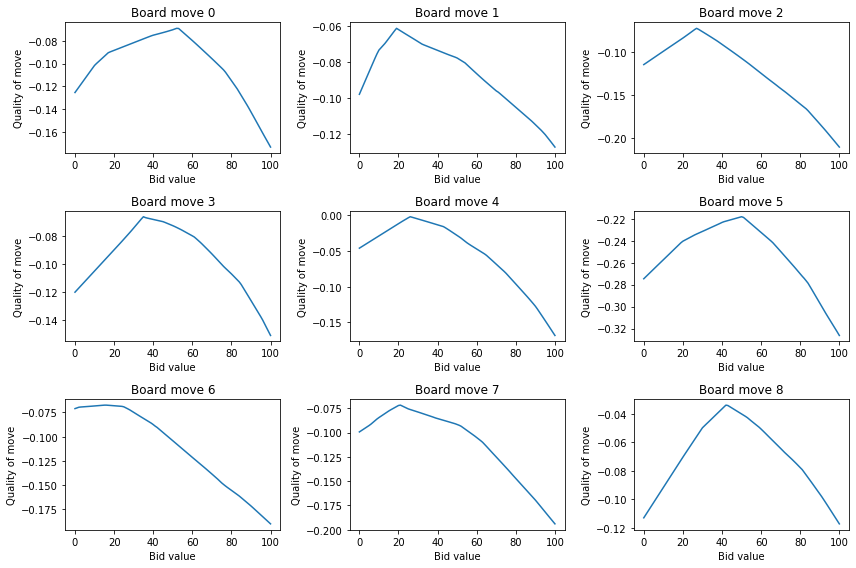

Animation of critic values saved!
Episode #50100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.023
                  Actor Loss: -0.855  |  Critic Loss: +0.139     |  Time Elapsed: 27170.60s
Episode #50200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.72  |  Epsilon: 0.023
                  Actor Loss: -0.817  |  Critic Loss: +0.155     |  Time Elapsed: 27229.88s
Episode #50300  |  Val. Score: +0.50   |  Avg. Val. Score: +0.73  |  Epsilon: 0.023
                  Actor Loss: -0.847  |  Critic Loss: +0.119     |  Time Elapsed: 27287.92s
Episode #50400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.73  |  Epsilon: 0.023
                  Actor Loss: -0.826  |  Critic Loss: +0.147     |  Time Elapsed: 27347.10s
Episode #50500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.78  |  Epsilon: 0.023
                  Actor Loss: -0.827  |  Critic Loss: +0.138     |  Time Elapsed: 27406.63s
Checkpoint saved!
Episode #50600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.82  | 

Episode #54700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.73  |  Epsilon: 0.017
                  Actor Loss: -0.869  |  Critic Loss: +0.144     |  Time Elapsed: 29966.16s
Episode #54800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.016
                  Actor Loss: -0.849  |  Critic Loss: +0.153     |  Time Elapsed: 30026.63s
Episode #54900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.71  |  Epsilon: 0.016
                  Actor Loss: -0.842  |  Critic Loss: +0.138     |  Time Elapsed: 30085.74s
Episode #55000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.72  |  Epsilon: 0.016
                  Actor Loss: -0.842  |  Critic Loss: +0.132     |  Time Elapsed: 30147.05s
Checkpoint saved!
Episode #55100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.016
                  Actor Loss: -0.875  |  Critic Loss: +0.123     |  Time Elapsed: 30207.95s
Episode #55200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.016
                  

Episode #59300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.70  |  Epsilon: 0.012
                  Actor Loss: -0.844  |  Critic Loss: +0.140     |  Time Elapsed: 32821.80s
Episode #59400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  |  Epsilon: 0.012
                  Actor Loss: -0.848  |  Critic Loss: +0.117     |  Time Elapsed: 32886.95s
Episode #59500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.67  |  Epsilon: 0.012
                  Actor Loss: -0.843  |  Critic Loss: +0.134     |  Time Elapsed: 32949.32s
Checkpoint saved!
Episode #59600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.73  |  Epsilon: 0.011
                  Actor Loss: -0.839  |  Critic Loss: +0.117     |  Time Elapsed: 33011.42s
Episode #59700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.011
                  Actor Loss: -0.875  |  Critic Loss: +0.118     |  Time Elapsed: 33075.59s
Episode #59800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.75  |  Epsilon: 0.011
                  

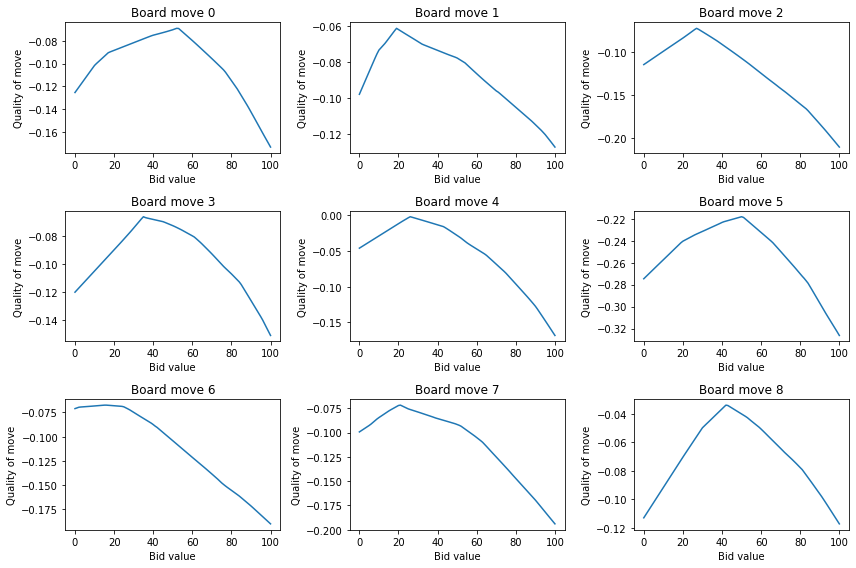

Animation of critic values saved!
Episode #60100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.83  |  Epsilon: 0.011
                  Actor Loss: -0.856  |  Critic Loss: +0.126     |  Time Elapsed: 33356.49s
Episode #60200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.011
                  Actor Loss: -0.850  |  Critic Loss: +0.131     |  Time Elapsed: 33419.12s
Episode #60300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.85  |  Epsilon: 0.011
                  Actor Loss: -0.833  |  Critic Loss: +0.134     |  Time Elapsed: 33482.99s
Episode #60400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.011
                  Actor Loss: -0.832  |  Critic Loss: +0.133     |  Time Elapsed: 33546.01s
Episode #60500  |  Val. Score: +0.50   |  Avg. Val. Score: +0.84  |  Epsilon: 0.011
                  Actor Loss: -0.834  |  Critic Loss: +0.135     |  Time Elapsed: 33608.84s
Checkpoint saved!
Episode #60600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  | 

Episode #64700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.853  |  Critic Loss: +0.119     |  Time Elapsed: 36281.24s
Episode #64800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.844  |  Critic Loss: +0.135     |  Time Elapsed: 36345.44s
Episode #64900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.835  |  Critic Loss: +0.127     |  Time Elapsed: 36410.13s
Episode #65000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.860  |  Critic Loss: +0.125     |  Time Elapsed: 36472.47s
Checkpoint saved!
Episode #65100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.860  |  Critic Loss: +0.152     |  Time Elapsed: 36537.37s
Episode #65200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  

Episode #69300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.881  |  Critic Loss: +0.159     |  Time Elapsed: 39271.11s
Episode #69400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.876  |  Critic Loss: +0.124     |  Time Elapsed: 39337.90s
Episode #69500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.865  |  Critic Loss: +0.130     |  Time Elapsed: 39405.88s
Checkpoint saved!
Episode #69600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -0.902  |  Critic Loss: +0.132     |  Time Elapsed: 39470.79s
Episode #69700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -0.858  |  Critic Loss: +0.153     |  Time Elapsed: 39535.26s
Episode #69800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  

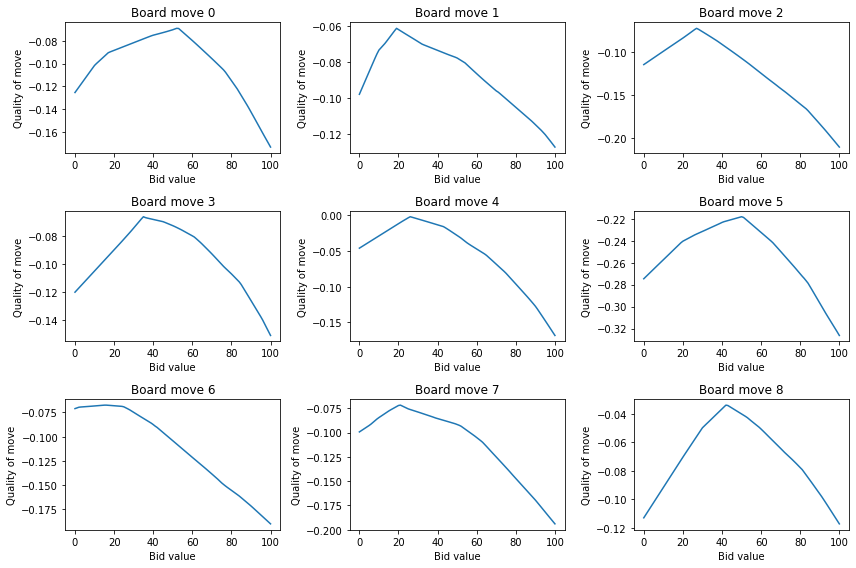

Animation of critic values saved!
Episode #70100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.874  |  Critic Loss: +0.123     |  Time Elapsed: 39825.43s
Episode #70200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.864  |  Critic Loss: +0.131     |  Time Elapsed: 39889.18s
Episode #70300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.870  |  Critic Loss: +0.149     |  Time Elapsed: 39956.68s
Episode #70400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.884  |  Critic Loss: +0.116     |  Time Elapsed: 40023.00s
Episode #70500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.848  |  Critic Loss: +0.158     |  Time Elapsed: 40089.22s
Checkpoint saved!
Episode #70600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.81  | 

Episode #74700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.65  |  Epsilon: 0.010
                  Actor Loss: -0.875  |  Critic Loss: +0.124     |  Time Elapsed: 42923.13s
Episode #74800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.010
                  Actor Loss: -0.893  |  Critic Loss: +0.133     |  Time Elapsed: 42992.68s
Episode #74900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.72  |  Epsilon: 0.010
                  Actor Loss: -0.852  |  Critic Loss: +0.138     |  Time Elapsed: 43060.95s
Episode #75000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -0.870  |  Critic Loss: +0.117     |  Time Elapsed: 43131.45s
Checkpoint saved!
Episode #75100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.867  |  Critic Loss: +0.137     |  Time Elapsed: 43201.40s
Episode #75200  |  Val. Score: +0.90   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  

Episode #79300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.868  |  Critic Loss: +0.133     |  Time Elapsed: 46084.06s
Episode #79400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.857  |  Critic Loss: +0.138     |  Time Elapsed: 46152.50s
Episode #79500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.848  |  Critic Loss: +0.148     |  Time Elapsed: 46223.99s
Checkpoint saved!
Episode #79600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.843  |  Critic Loss: +0.141     |  Time Elapsed: 46294.81s
Episode #79700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.855  |  Critic Loss: +0.144     |  Time Elapsed: 46366.03s
Episode #79800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  

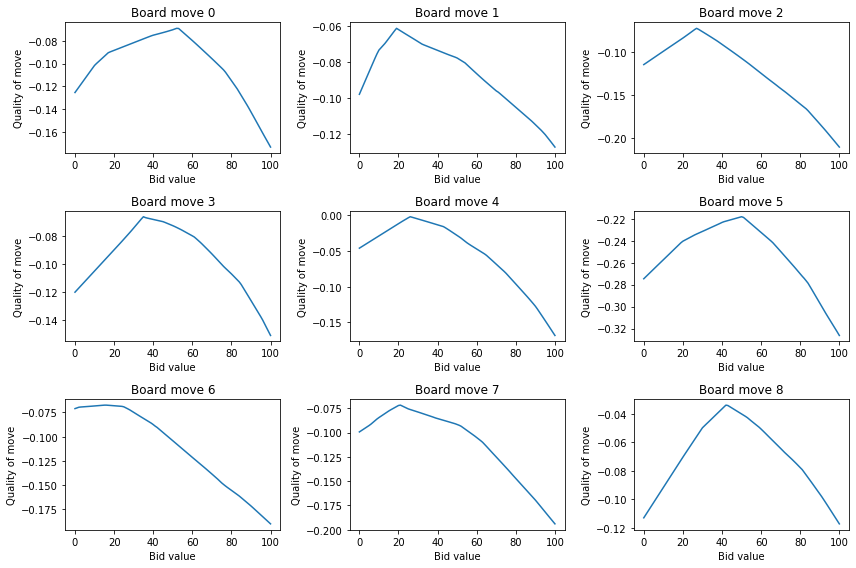

Animation of critic values saved!
Episode #80100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.873  |  Critic Loss: +0.120     |  Time Elapsed: 46681.99s
Episode #80200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.862  |  Critic Loss: +0.118     |  Time Elapsed: 46749.54s
Episode #80300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.861  |  Critic Loss: +0.121     |  Time Elapsed: 46818.65s
Episode #80400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.864  |  Critic Loss: +0.125     |  Time Elapsed: 46889.50s
Episode #80500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.859  |  Critic Loss: +0.135     |  Time Elapsed: 46961.12s
Checkpoint saved!
Episode #80600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  | 

Episode #84700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.865  |  Critic Loss: +0.128     |  Time Elapsed: 49927.76s
Episode #84800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.866  |  Critic Loss: +0.136     |  Time Elapsed: 49997.81s
Episode #84900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.847  |  Critic Loss: +0.124     |  Time Elapsed: 50072.15s
Episode #85000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.865  |  Critic Loss: +0.139     |  Time Elapsed: 50143.23s
Checkpoint saved!
Episode #85100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.859  |  Critic Loss: +0.135     |  Time Elapsed: 50213.60s
Episode #85200  |  Val. Score: +0.90   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  

Episode #89300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.814  |  Critic Loss: +0.144     |  Time Elapsed: 53252.76s
Episode #89400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.853  |  Critic Loss: +0.124     |  Time Elapsed: 53326.01s
Episode #89500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.845  |  Critic Loss: +0.124     |  Time Elapsed: 53396.88s
Checkpoint saved!
Episode #89600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.836  |  Critic Loss: +0.118     |  Time Elapsed: 53472.98s
Episode #89700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.834  |  Critic Loss: +0.125     |  Time Elapsed: 53545.52s
Episode #89800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  

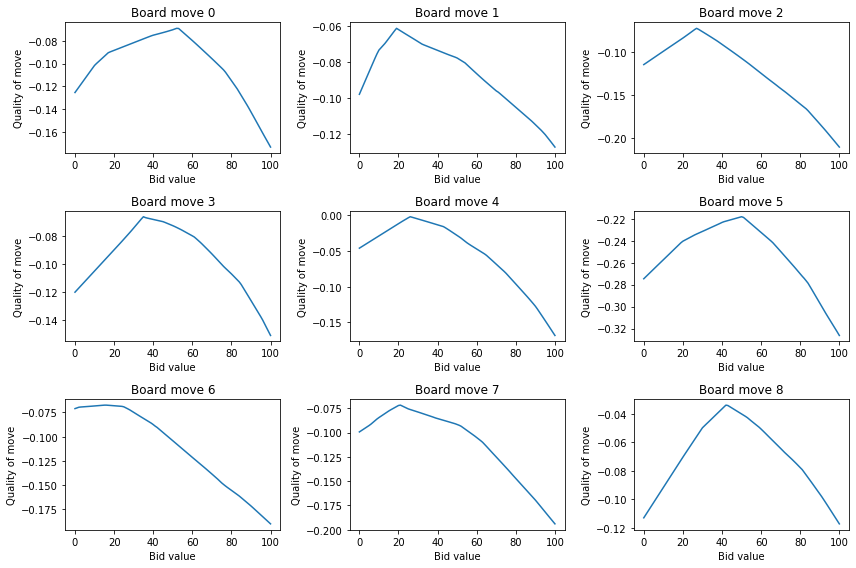

Animation of critic values saved!
Episode #90100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.835  |  Critic Loss: +0.139     |  Time Elapsed: 53875.38s
Episode #90200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.837  |  Critic Loss: +0.131     |  Time Elapsed: 53949.24s
Episode #90300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.834  |  Critic Loss: +0.123     |  Time Elapsed: 54025.09s
Episode #90400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.843  |  Critic Loss: +0.125     |  Time Elapsed: 54096.20s
Episode #90500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.841  |  Critic Loss: +0.122     |  Time Elapsed: 54171.55s
Checkpoint saved!
Episode #90600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.82  | 

Episode #94700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.824  |  Critic Loss: +0.111     |  Time Elapsed: 57240.41s
Episode #94800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.843  |  Critic Loss: +0.137     |  Time Elapsed: 57311.89s
Episode #94900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.852  |  Critic Loss: +0.107     |  Time Elapsed: 57380.02s
Episode #95000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.844  |  Critic Loss: +0.124     |  Time Elapsed: 57449.15s
Checkpoint saved!
Episode #95100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.852  |  Critic Loss: +0.139     |  Time Elapsed: 57520.53s
Episode #95200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  

Episode #99300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.840  |  Critic Loss: +0.110     |  Time Elapsed: 60541.46s
Episode #99400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.828  |  Critic Loss: +0.127     |  Time Elapsed: 60612.99s
Episode #99500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.805  |  Critic Loss: +0.121     |  Time Elapsed: 60685.79s
Checkpoint saved!
Episode #99600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.834  |  Critic Loss: +0.123     |  Time Elapsed: 60759.04s
Episode #99700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.831  |  Critic Loss: +0.135     |  Time Elapsed: 60830.91s
Episode #99800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  

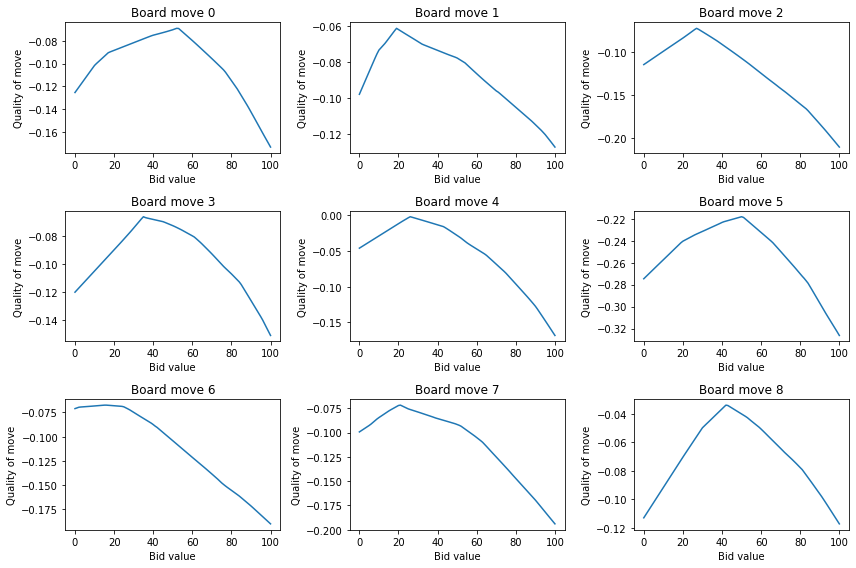

Animation of critic values saved!
Model saved!


In [11]:
n_episodes=100000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=1000
save_animation_each=10000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999925
players = [
    DRLPlayer(0, controller.game, drl_agent, train_mode=True),
]
if TRAIN_MODE == 'self_play':
    players.append(DRLPlayer(1, controller.game, drl_agent, train_mode=True))
elif TRAIN_MODE == 'random':
    players.append(RandomPlayer(1))
elif TRAIN_MODE == 'semi_random':
    players.append(SemiRandomPlayer(1, controller.game))
validation_scores, critic_values_by_episode = init_train(controller, players, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [12]:
len(critic_values_by_episode)

100

In [13]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #100100  |  Val. Score: -1.00   |  Avg. Val. Score: -1.00  |  Epsilon: 0.010
                  Actor Loss: -0.377  |  Critic Loss: +0.230     |  Time Elapsed: 56.90s
Episode #100200  |  Val. Score: -1.00   |  Avg. Val. Score: -1.00  |  Epsilon: 0.010
                  Actor Loss: -0.300  |  Critic Loss: +0.179     |  Time Elapsed: 106.11s
Episode #100300  |  Val. Score: -0.60   |  Avg. Val. Score: -0.87  |  Epsilon: 0.010
                  Actor Loss: -0.437  |  Critic Loss: +0.122     |  Time Elapsed: 167.08s
Episode #100400  |  Val. Score: -0.60   |  Avg. Val. Score: -0.80  |  Epsilon: 0.010
                  Actor Loss: -0.465  |  Critic Loss: +0.121     |  Time Elapsed: 236.39s
Episode #100500  |  Val. Score: -0.80   |  Avg. Val. Score: -0.80  |  Epsilon: 0.010
                  Actor Loss: -0.479  |  Critic Loss: +0.131     |  Time Elapsed: 307.36s
Checkpoint saved!
Episode #100600  |  Val. Score: -0.20   |  Avg. Val. Score: -0.70  |  Epsilon: 0.010
                  Actor

Episode #104700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.793  |  Critic Loss: +0.145     |  Time Elapsed: 3556.28s
Episode #104800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.805  |  Critic Loss: +0.127     |  Time Elapsed: 3643.28s
Episode #104900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.796  |  Critic Loss: +0.146     |  Time Elapsed: 3729.74s
Episode #105000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.805  |  Critic Loss: +0.128     |  Time Elapsed: 3818.97s
Checkpoint saved!
Episode #105100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.808  |  Critic Loss: +0.124     |  Time Elapsed: 3905.77s
Episode #105200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                 

Episode #109300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.762  |  Critic Loss: +0.136     |  Time Elapsed: 7544.02s
Episode #109400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.769  |  Critic Loss: +0.133     |  Time Elapsed: 7628.56s
Episode #109500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.780  |  Critic Loss: +0.153     |  Time Elapsed: 7716.70s
Checkpoint saved!
Episode #109600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.803  |  Critic Loss: +0.122     |  Time Elapsed: 7799.88s
Episode #109700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.821  |  Critic Loss: +0.108     |  Time Elapsed: 7878.18s
Episode #109800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                 

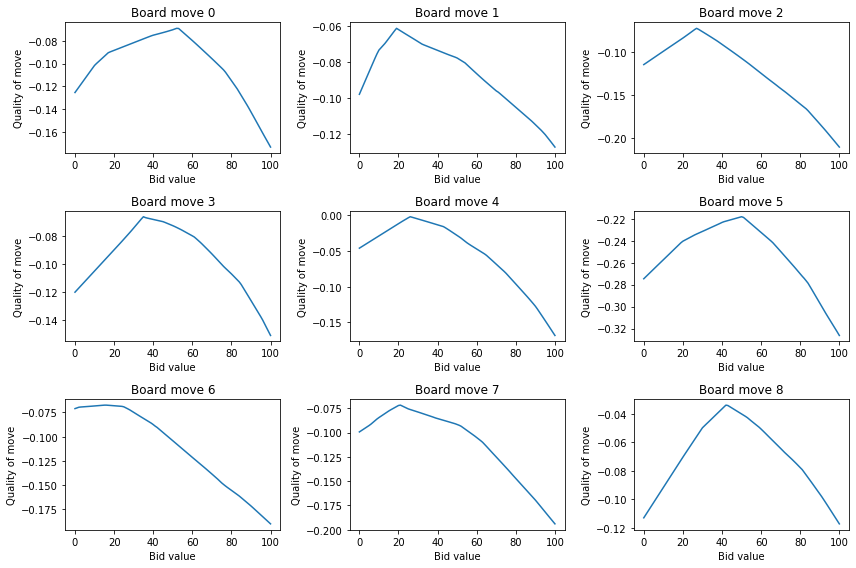

Animation of critic values saved!
Episode #110100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.796  |  Critic Loss: +0.127     |  Time Elapsed: 8244.06s
Episode #110200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.809  |  Critic Loss: +0.144     |  Time Elapsed: 8322.21s
Episode #110300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.814  |  Critic Loss: +0.138     |  Time Elapsed: 8400.29s
Episode #110400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.803  |  Critic Loss: +0.144     |  Time Elapsed: 8481.38s
Episode #110500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.804  |  Critic Loss: +0.145     |  Time Elapsed: 8561.92s
Checkpoint saved!
Episode #110600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |

Episode #114700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.782  |  Critic Loss: +0.138     |  Time Elapsed: 12168.61s
Episode #114800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  Actor Loss: -0.788  |  Critic Loss: +0.121     |  Time Elapsed: 12254.76s
Episode #114900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.775  |  Critic Loss: +0.123     |  Time Elapsed: 12340.13s
Episode #115000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.772  |  Critic Loss: +0.133     |  Time Elapsed: 12424.00s
Checkpoint saved!
Episode #115100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.776  |  Critic Loss: +0.116     |  Time Elapsed: 12510.16s
Episode #115200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
            

Episode #119300  |  Val. Score: +1.00   |  Avg. Val. Score: +1.00  |  Epsilon: 0.010
                  Actor Loss: -0.764  |  Critic Loss: +0.137     |  Time Elapsed: 16254.46s
Episode #119400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.99  |  Epsilon: 0.010
                  Actor Loss: -0.753  |  Critic Loss: +0.144     |  Time Elapsed: 16341.53s
Episode #119500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.777  |  Critic Loss: +0.131     |  Time Elapsed: 16424.33s
Checkpoint saved!
Episode #119600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.784  |  Critic Loss: +0.130     |  Time Elapsed: 16508.68s
Episode #119700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.796  |  Critic Loss: +0.117     |  Time Elapsed: 16593.54s
Episode #119800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
            

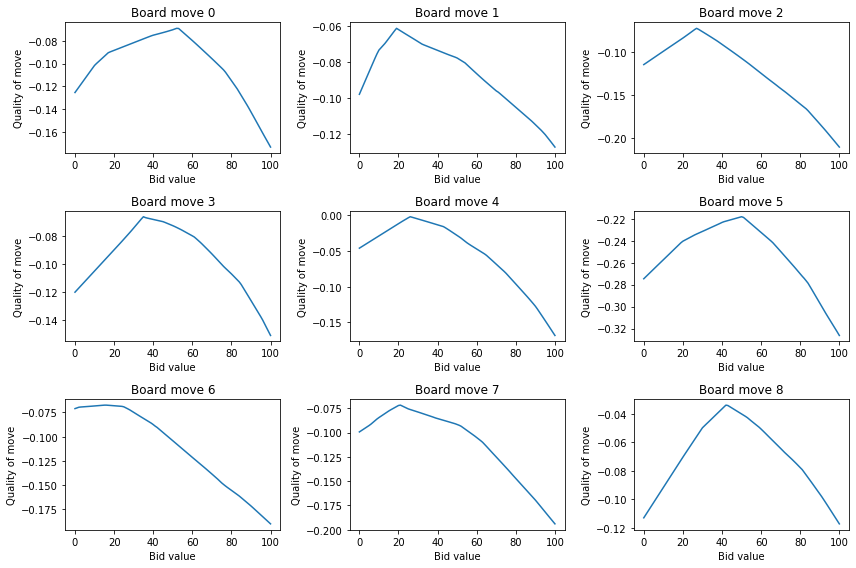

Animation of critic values saved!
Episode #120100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.760  |  Critic Loss: +0.134     |  Time Elapsed: 16987.34s
Episode #120200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.766  |  Critic Loss: +0.125     |  Time Elapsed: 17070.18s
Episode #120300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.769  |  Critic Loss: +0.128     |  Time Elapsed: 17157.89s
Episode #120400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.770  |  Critic Loss: +0.122     |  Time Elapsed: 17242.53s
Episode #120500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.753  |  Critic Loss: +0.133     |  Time Elapsed: 17327.30s
Checkpoint saved!
Episode #120600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.

Episode #124700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.827  |  Critic Loss: +0.134     |  Time Elapsed: 21097.03s
Episode #124800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.830  |  Critic Loss: +0.141     |  Time Elapsed: 21191.69s
Episode #124900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.842  |  Critic Loss: +0.128     |  Time Elapsed: 21287.24s
Episode #125000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.828  |  Critic Loss: +0.131     |  Time Elapsed: 21382.89s
Checkpoint saved!
Episode #125100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.96  |  Epsilon: 0.010
                  Actor Loss: -0.830  |  Critic Loss: +0.128     |  Time Elapsed: 21481.61s


In [ ]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, players,
                    start_epoch=100001, critic_values_by_episode=critic_values_by_episode, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=50000, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [ ]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

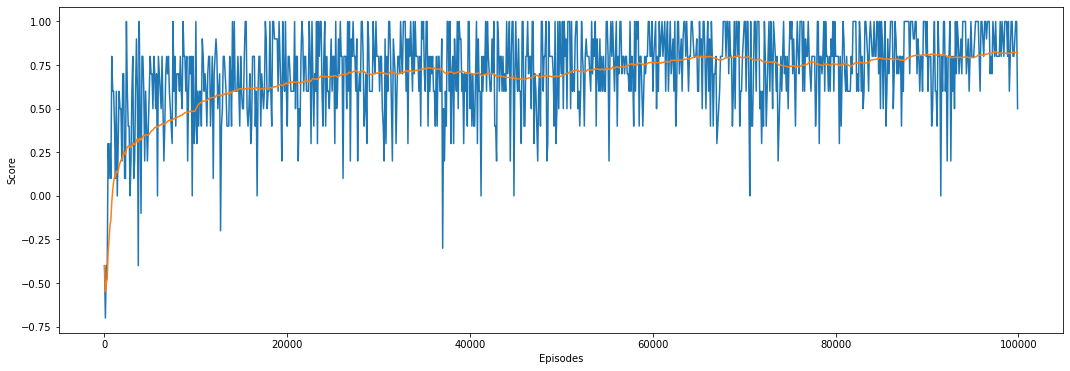

In [16]:
plot_scores(final_validation_scores, validate_each)

In [17]:
drl_agent.save_model(f'../checkpoints/{MODEL_VERSION}_model_final.pt')

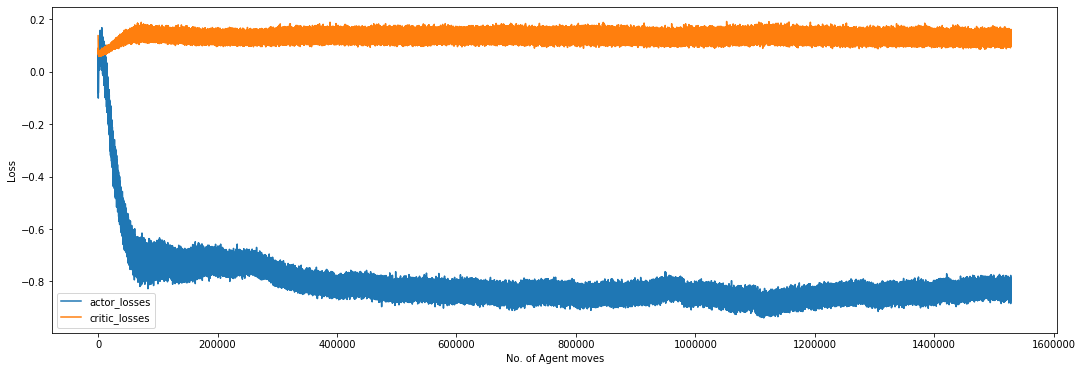

In [18]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [19]:
# controller.reset_game(drl_checkpoint_path=f'../checkpoints/{MODEL_VERSION}_model.pt')

In [20]:
run_validation(players, 1000)

-0.976